# Benjamin Lavoie (benjaminlavoie02@gmail.com)

# CapStone project: Gaming Score Forecasting Model

# Last update: March 31st, 2024 (version 3.2)

# Notebook 2: Pre-processing and Processing

# Table of Contents

**[3. Part 3 - Introduction (2nd Notebook)](#heading--3)**

  * [3.1 - Data Dictionary](#heading--3-1)

  * [3.2 - Separating the dataframe](#heading--3-2)

  * [3.3 - One hot encoding (dummy variables)](#heading--3-3)
  
  * [3.4 - Columns to vectorize with TFDIF](#heading--3-4)
    
  * [3.5 - Variance Threshold](#heading--3-5)
  
<br>

**[4. Part 4 - Modeling](#heading--4)**
  
  * [4.1 - Logistic Regression Part 1](#heading--4-1)
      * [4.1.1 - Logistic Regression coefficient graph](#heading--4-1-1)
      * [4.1.2 - Logistic Regression Top 10 feature distributions](#heading--4-1-2)
  * [4.1.3 - Logistic Regression Part 2](#heading--4-1-3)
  
  * [4.2 - Pipeline test](#heading--4-2)
  
  * [4.3 - 6 different models](#heading--4-3)
  
  * [4.4 - XG Boost](#heading--4-4)
      * [4.4.1 - XG Boost Top 20 feature importances](#heading--4-4-1)
  
  <br>
  
**[5. Part 5 - Modeling results](#heading--5)**
  
  * [5.1 - Scores](#heading--5-1)
  
  * [5.2 - Confusion Matrix](#heading--5-2)
  
<br>

**[6. Part 6 - Conclusion](#heading--6)**
  
  * [6.1 - Export for Streamlit deployment](#heading--6-1)
  

Let's start by importing all the necessary libraries for this notebook (preprocessing, modelling, exporting/deploying).

In [1]:

# Necessary libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import nltk
import statsmodels.api as sm
import glob
import os
from scipy.stats import chi2_contingency


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# To plot
from scipy import stats
from scipy.stats import norm 

# To split the data as necessary for modelling
from sklearn.model_selection import train_test_split

# To process text data
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string

# To get rid of logistic regression default solver warnings that appear if sklearn hasn't been updated
import warnings
warnings.filterwarnings('ignore')

# To "pickle" things, like accuracies or even an entire fitted model
import joblib

# To cross-validate
from sklearn.model_selection import cross_val_score

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp

# To build a pipeline
from sklearn.pipeline import Pipeline

# To do dimensionality reduction
from sklearn.decomposition import PCA

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold



#imporint different models

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier


# To see more columns at once, I'll change the display.max_columns number
pd.set_option('display.max_columns', 50)

<div id="heading--3"/>

# 3. Part 3 - Introduction (2nd Notebook)

The cleaning and the EDA has all been done in the 1st Notebook.

In this 2nd Notebook, I will be doing the pre-processing as well as the processing/modeling.

I will start importing the data set, and then by separating the dataset. Since I have 14k+ rows and not 100k+ rows, I'll keep only 20% for the testing.

<div id="heading--3-1"/>

## 3.1 - Data Dictionary:

| Feature/Column | Definition | Data type |
|----------|----------|----------|
| Name | Name/Title of the game | String |
| Platform | Platform the game was released on | String |
| Publisher | Publisher of the game | String |
| Developer | Developer of the game | String |
| Genre | Genre of the game | String |
| Platform_Brand | Brand of the platform (Nintendo, Sony, Microsoft, PC | String |
| Platform_Type | Type of the platform (HomeConsole, Handheld, PC) | String |
| Release_Date | Release date | DateTime |
| Release_Day | Release day | int |
| Release_Month | Release month | int |
| Release_Year | Release year | int |
| Metascore_Range | Classification: Weak, Okay or Strong | String |

In [2]:
df = pd.read_csv('clean_data_2.0.csv', index_col='Unnamed: 0', header=0)

In [3]:
df.head(5)

Name Platform   Publisher            Developer  \
0                        Wii Sports      Wii  Nintendo         Nintendo EAD     
1               Mario Kart 8 Deluxe       NS  Nintendo         Nintendo EPD     
2                   Team Fortress 2       PC     Valve    Valve Corporation     
3  Counter-Strike: Global Offensive       PC     Valve    Valve Corporation     
4  Counter-Strike: Global Offensive       PC     Valve    Valve Corporation     

     Genre Platform_Brand Platform_Type Release_Date  Release_Day  \
0   Sports       Nintendo   HomeConsole   2006-11-19           19   
1   Racing       Nintendo   HomeConsole   2017-04-28           28   
2  Shooter             PC            PC   2007-10-10           10   
3  Shooter             PC            PC   2012-08-21           21   
4  Shooter             PC            PC   2015-10-23           23   

   Release_Month  Release_Year Metascore_Range  
0             11          2006            Okay  
1              4          2017          Strong  
2             10          2007          Strong  
3              8          2012          Strong  
4             10          2015          Strong

<div id="heading--3-2"/>

## 3.2 - Separating the dataframe

Let's separate the data in train and test sets.

In [4]:
# dropping those columns because we won't need them.
df.drop(['Platform', 'Release_Date', 'Release_Day','Release_Month', 'Release_Year'], axis = 1, inplace=True)

In [5]:
# separating into X and y
X = df.drop(columns="Metascore_Range")
y = df["Metascore_Range"]


# Separating into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

# resetting the indexes to be able to separate the review columns and concatenate them easily later
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)


# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train)} data points.')
print(f'The TEST set has {len(X_test)} data points.')

The TRAIN set has 10783 data points.
The TEST set has 3595 data points.


<div id="heading--3-3"/>

## 3.3 - One hot encoding (dummy variables)

<br>

I will transform some of the columns into dummy variables
- Platform (testing with and without)
- Genre
- Platform_Brand
- Platform_Type

In [6]:
# put columns to transform in X_train_numerical, then transforming them
X_train_numerical = X_train[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_train_dummy = pd.get_dummies(X_train_numerical, dtype=np.int32)

# same thing, but with X_test
X_test_numerical = X_test[['Genre', 'Platform_Brand', 'Platform_Type']].copy()
X_test_dummy = pd.get_dummies(X_test_numerical, dtype=np.int32)

# concatenating back together
X_train = pd.concat([X_train, X_train_dummy], axis="columns")
X_test = pd.concat([X_test, X_test_dummy], axis="columns")

# dropping the columns that were transformed in dummy variables
X_train.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)
X_test.drop(['Genre', 'Platform_Brand', 'Platform_Type'], axis = 1, inplace=True)


Because I did some hot encoding, I now will check collinearity.
Depending on collinearity, I might have to drop at least one column per pre-dummy columns.
Let's check it out.

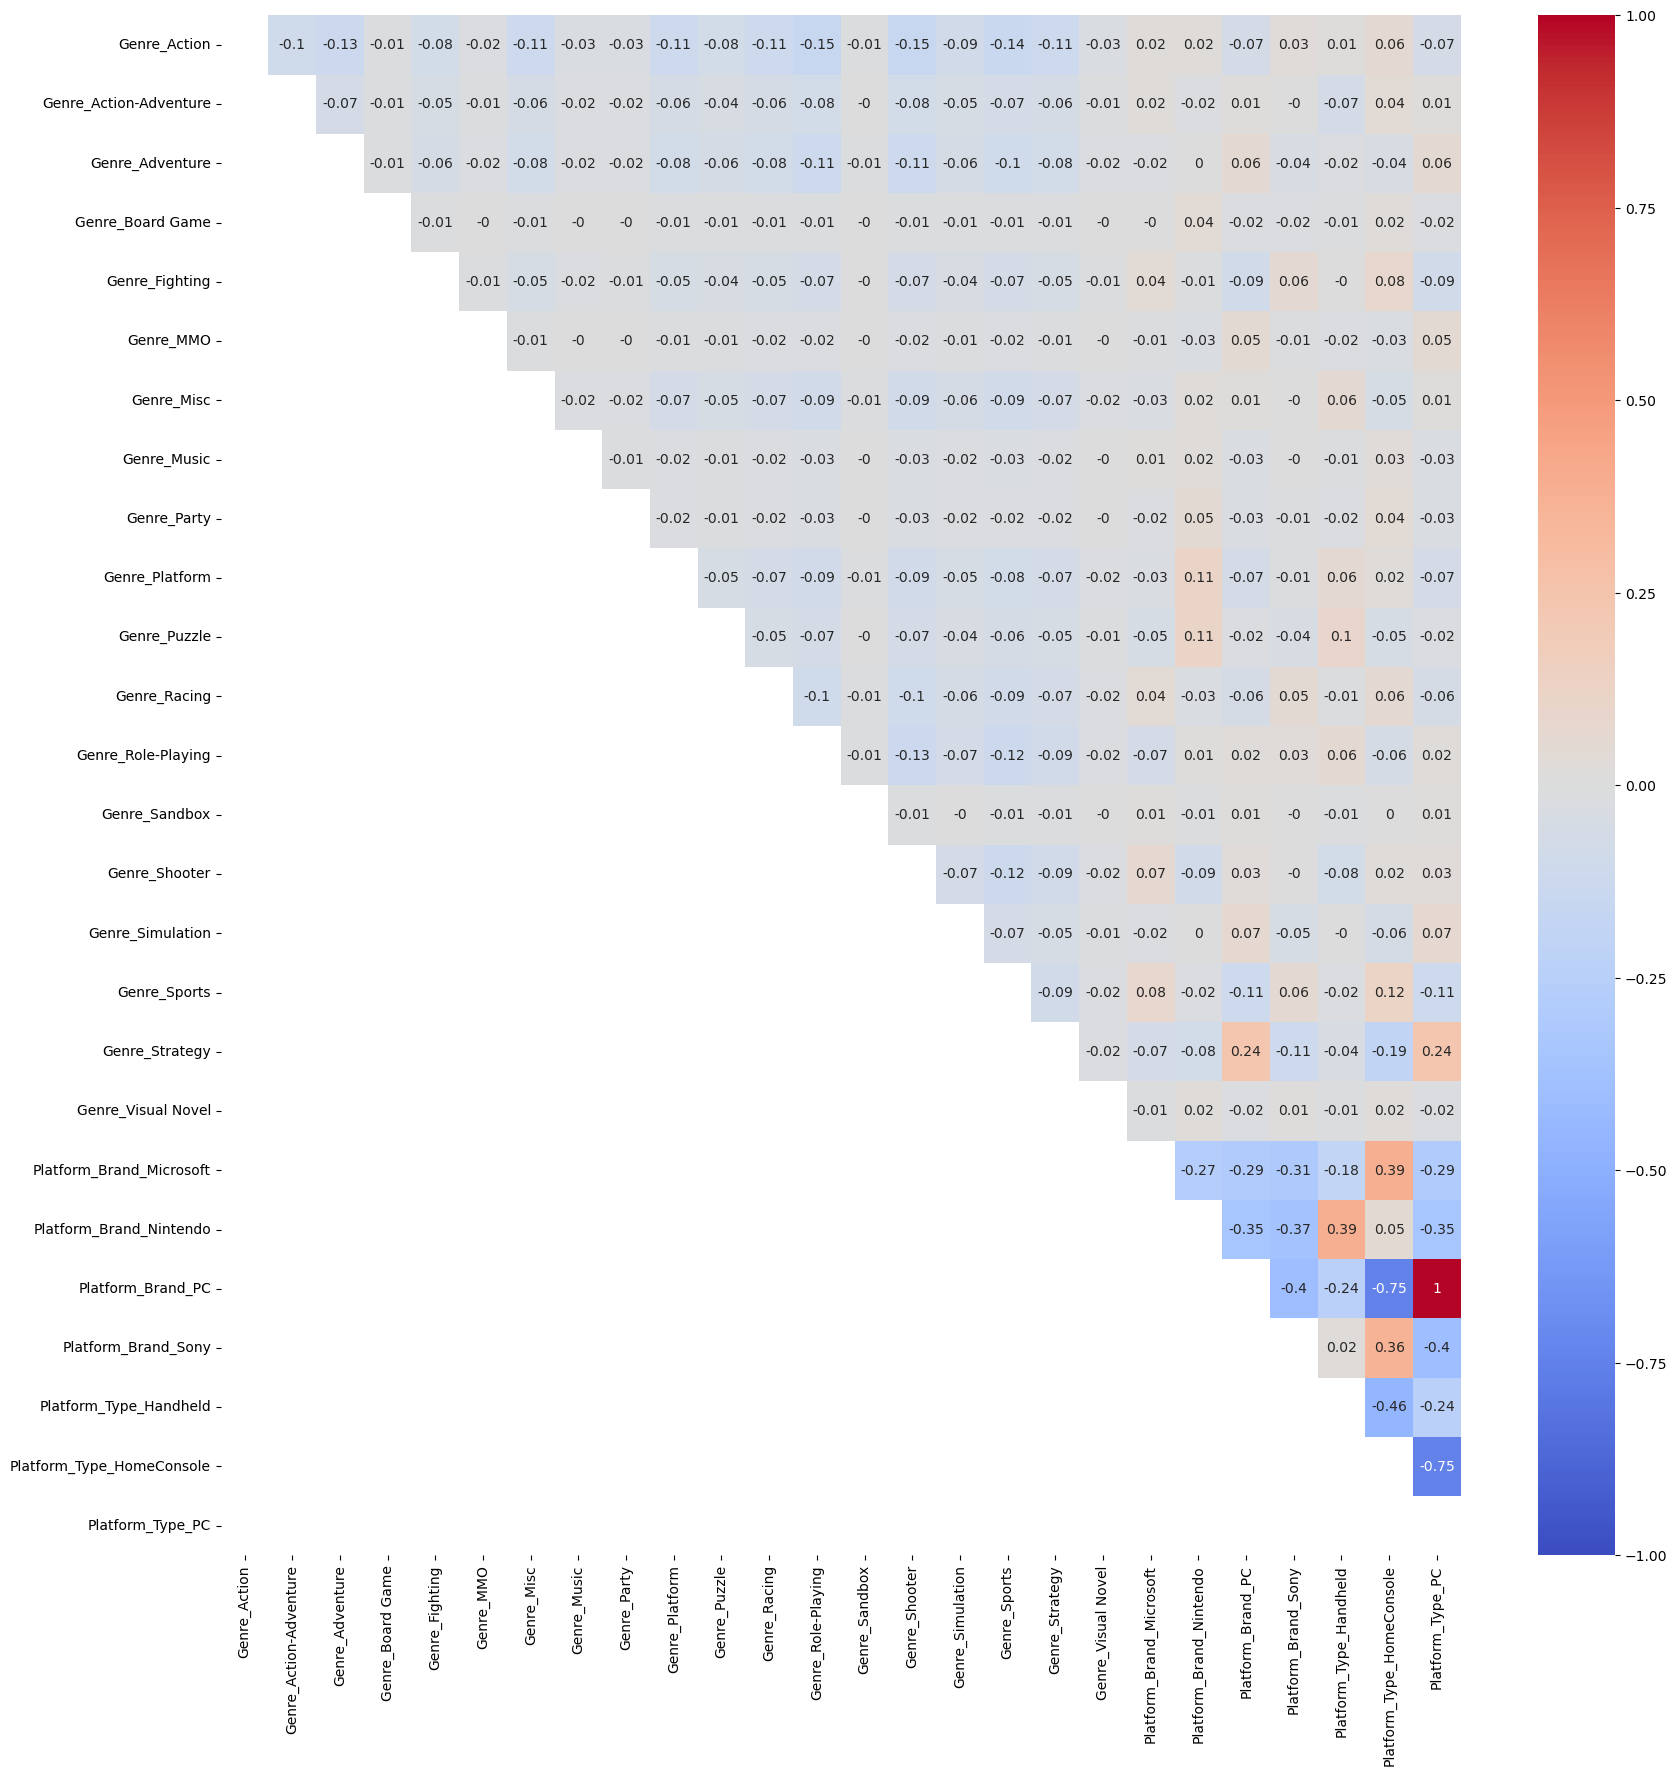

In [7]:
# dropping my non-numerical columns
X_train_corr = X_train.drop(columns=["Name", "Publisher", "Developer"])

# calculating the correlation
corr_df = X_train_corr.corr().round(2)

# mask to show only half the values (because they are mirrored anyway)
mask = np.tril(np.ones_like(corr_df))

# plotting for easy visualization
plt.figure(figsize=(20,20))
sns.heatmap(corr_df, cmap='coolwarm', vmin=-1, vmax=1, annot=True, mask = mask)
plt.show()

From what I can see above, there is indeed some collinearity between Platfform_Brand_PC and Platform_Type_PC. Now that I think about it, it is pretty obvious that there would be collinearity between those two.

I decided to drop Platform_Brand_PC and only keep Platform_Type PC

In [8]:
X_train.drop(["Platform_Brand_PC"], axis = 1, inplace=True)
X_test.drop(["Platform_Brand_PC"], axis = 1, inplace=True)

Let's check the collinearity again.

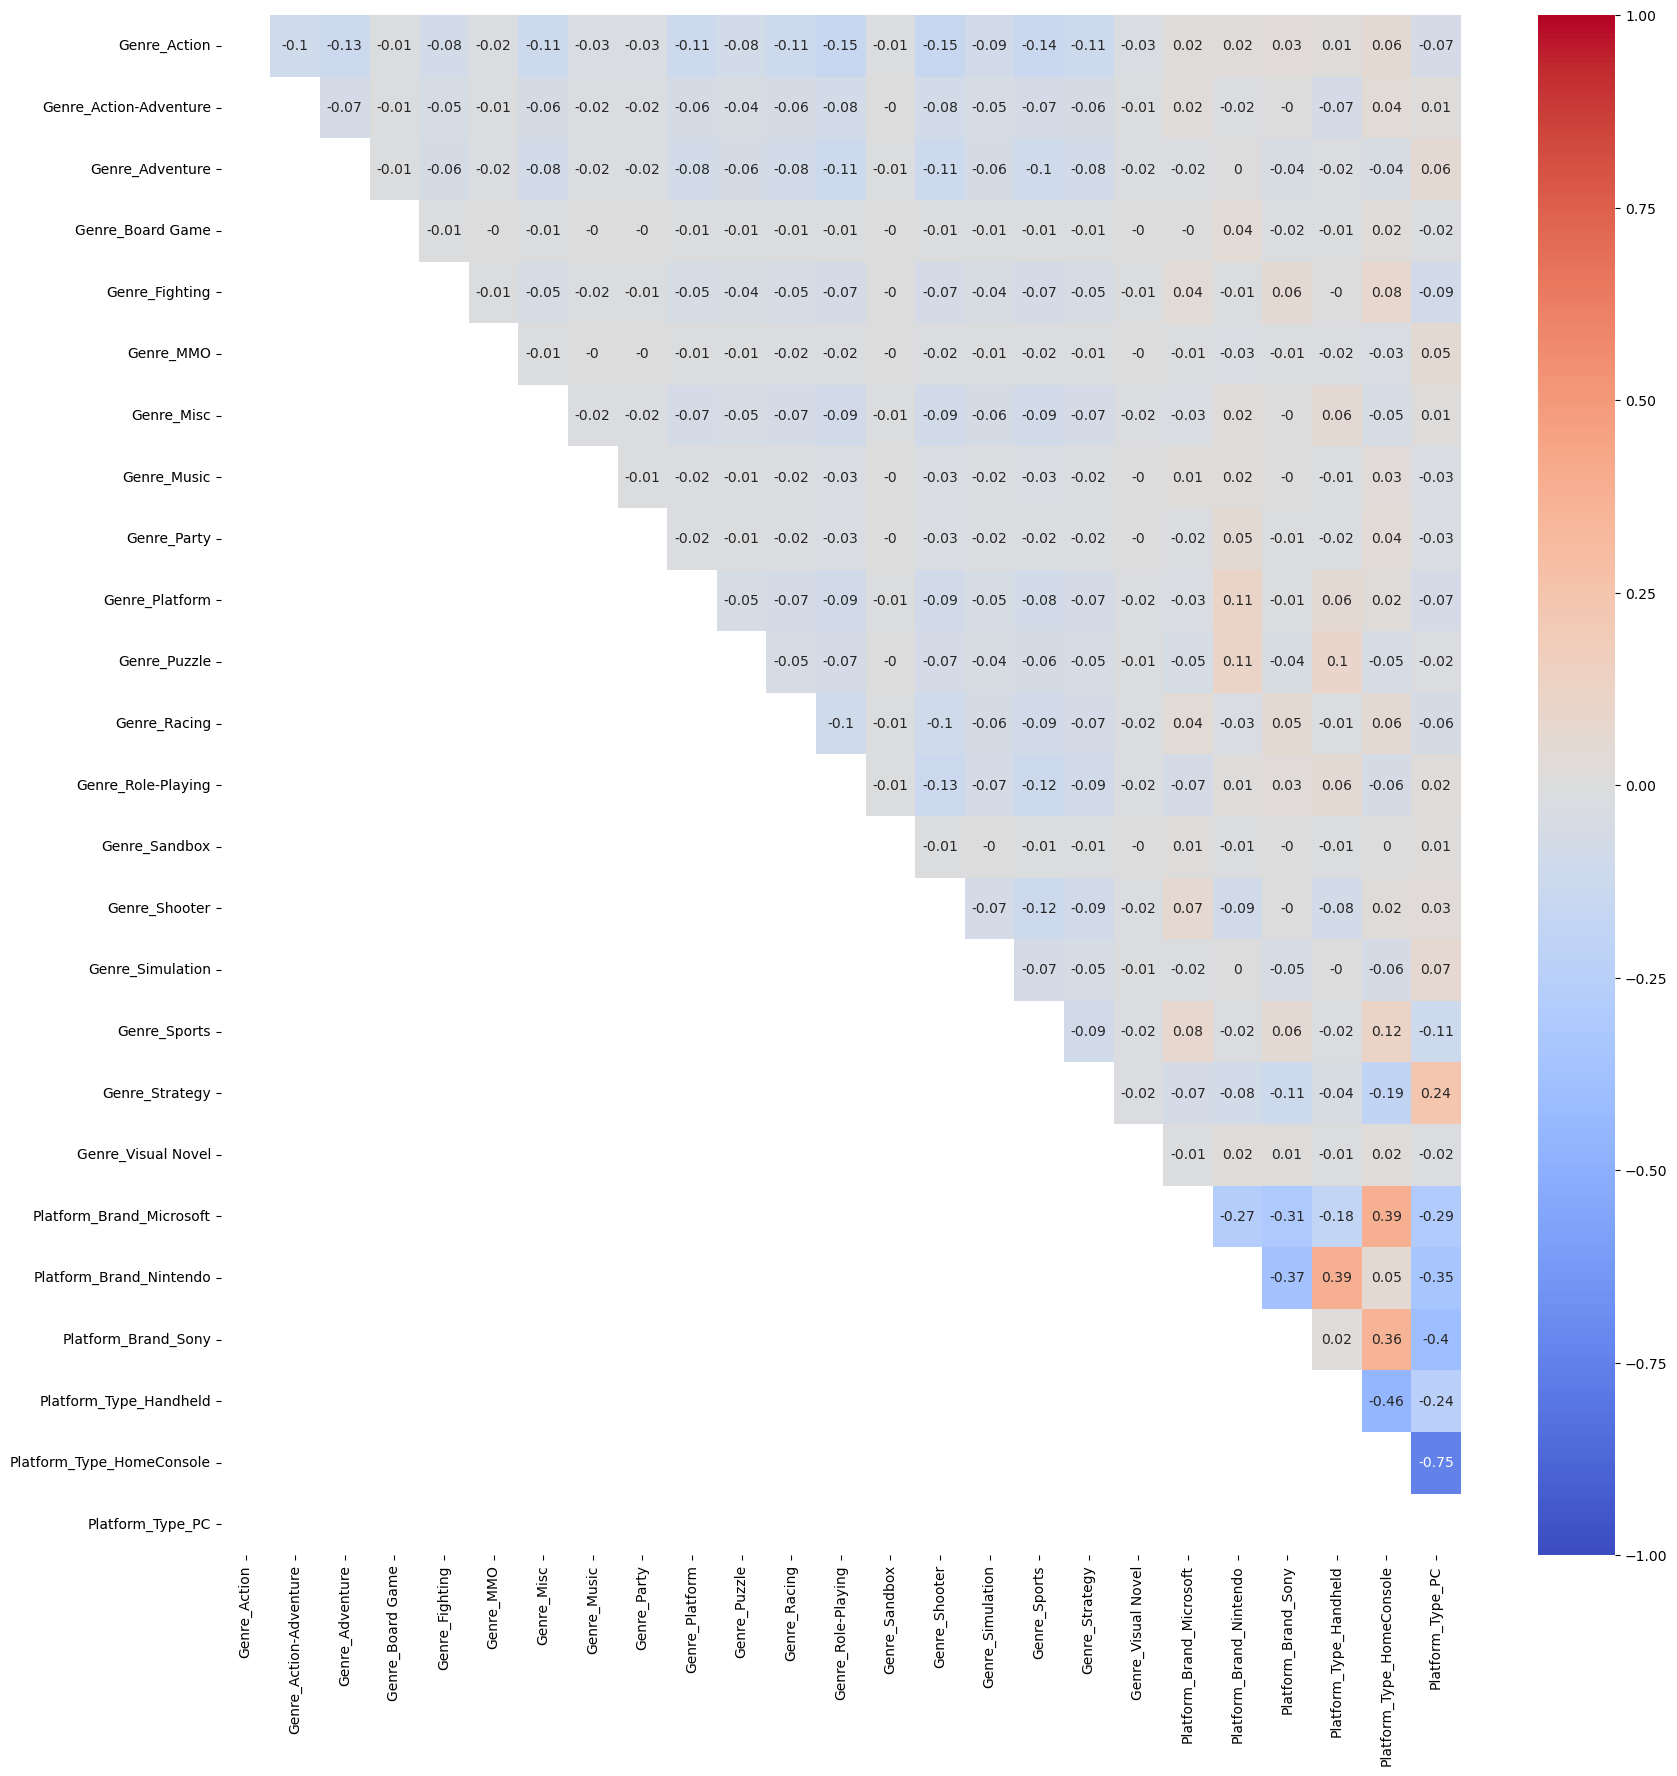

In [9]:
# dropping my non-numerical columns
X_train_corr = X_train.drop(columns=["Name", "Publisher", "Developer"])

# calculating the correlation
corr_df = X_train_corr.corr().round(2)

# mask to show only half the values (because they are mirrored anyway)
mask = np.tril(np.ones_like(corr_df))

# plotting for easy visualization
plt.figure(figsize=(20,20))
sns.heatmap(corr_df, cmap='coolwarm', vmin=-1, vmax=1, annot=True, mask = mask)
plt.show()

I know there is high collinearity between Platform_Type_PC and Platform_Type_HomeConsole, but I would prefer not to drop any of those. I will keep it as is.

In [10]:
# sanity check with all the dfs

print(X_train_numerical.shape)
print(X_train_dummy.shape)
print(X_test_numerical.shape)
print(X_test_dummy.shape)
print(X_train.shape)
print(X_test.shape)
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())

(10783, 3)
(10783, 26)
(3595, 3)
(3595, 26)
(10783, 28)
(3595, 28)
0
0


I think that using a NLP is a good idea, so I will use TF IDF to create more features. Then, I will be able to continue the processing.

<div id="heading--3-4"/>

## 3.4 - Columns to vectorize with TFDIF

Before vectorizing, I will create a my_tokenizer function to tokenize properly some columns

In [11]:
stemmer = nltk.stem.PorterStemmer()

ENGLISH_STOP_WORDS = stopwords.words('english')

# Custom stopwords to be added

custom_stopwords = []
custom_stopwords = ['game', 'games', 'unknown', 'studio', 'inc', 'ltd', 'studios']

# Extend stopwords with custom stopwords
ENGLISH_STOP_WORDS.extend(custom_stopwords)

# my_tokenizer function, to be used when vectorizing
def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

Now, I will vectorize 3 columns: Name, Publisher and Developer.

Under the code, I will also create histograms to show the 20 most weighted words in each column.

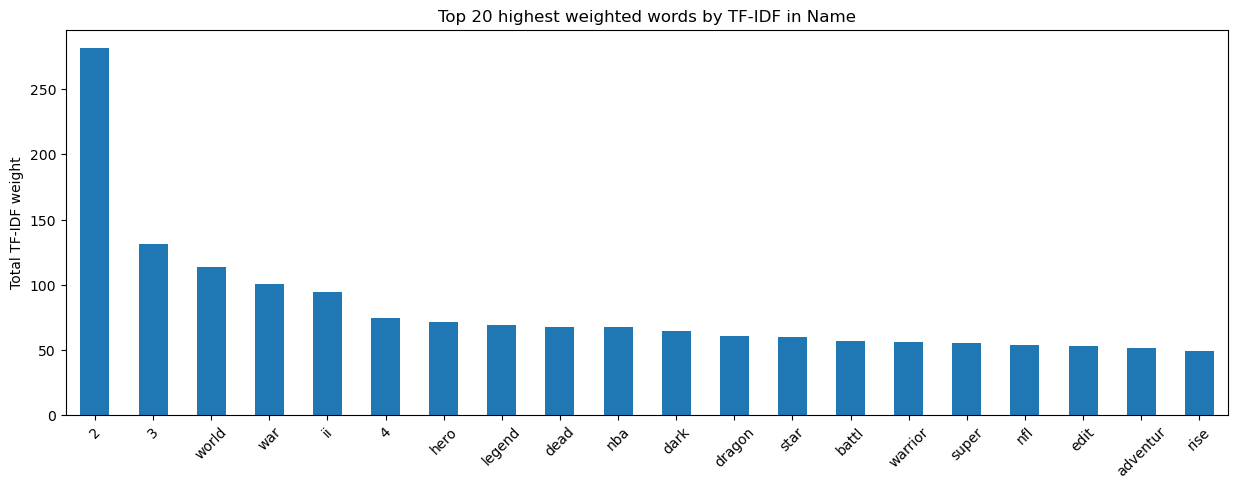

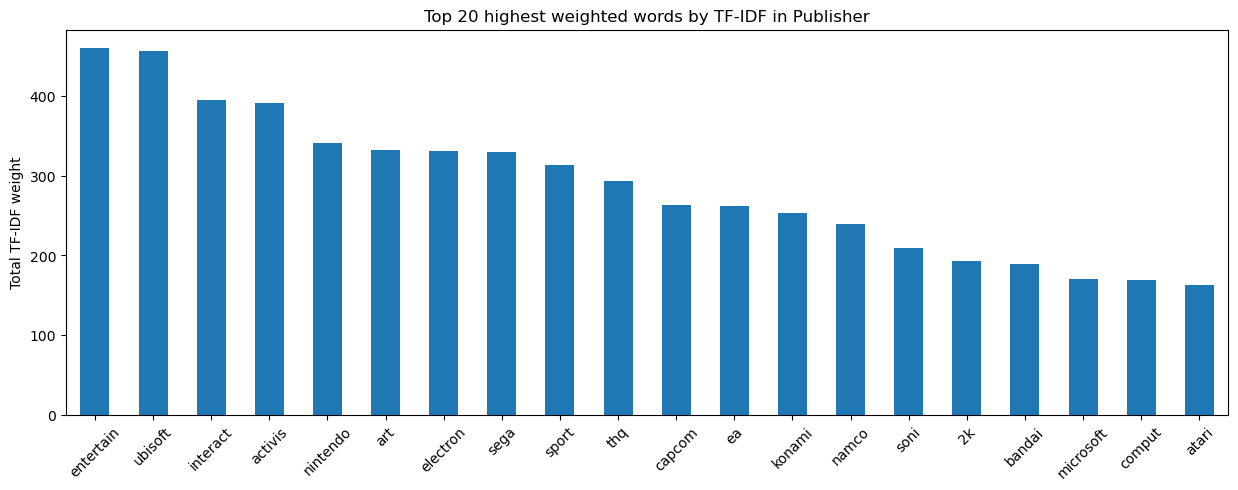

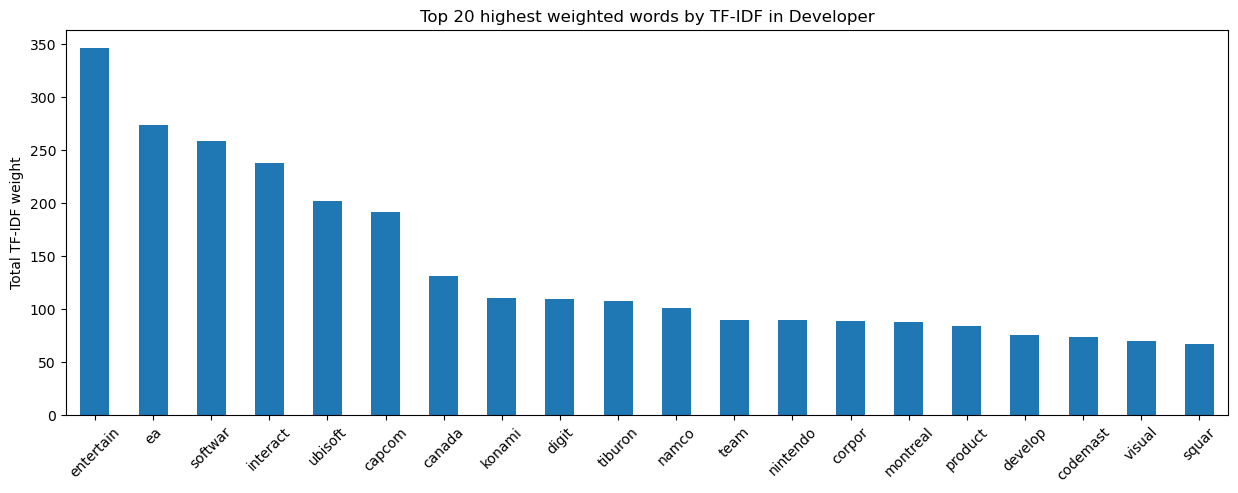

In [12]:
tfidf_columns = ['Name', 'Publisher', 'Developer']
tfidf_columns_variables = ['tfidf_Name', 'tfidf_Publisher', 'tfidf_Developer']


tfidf_dfs = []
X_train_keep = pd.DataFrame()

for i, col in enumerate(tfidf_columns):

    globals()[tfidf_columns_variables[i]] = TfidfVectorizer(tokenizer = my_tokenizer, min_df=4)

    # Fit and transform the text data
    transformed_train = globals()[tfidf_columns_variables[i]].fit_transform(X_train[col])
    transformed_test = globals()[tfidf_columns_variables[i]].transform(X_test[col])
    
    # store my vectorizers
    tfidf_dfs.append(globals()[tfidf_columns_variables[i]])

    # Convert the transformed data into a dataframe
    tfidf_df_train = pd.DataFrame(transformed_train.toarray(),
                                   columns=globals()[tfidf_columns_variables[i]].get_feature_names_out())

    tfidf_df_test = pd.DataFrame(transformed_test.toarray(),
                                   columns=globals()[tfidf_columns_variables[i]].get_feature_names_out())


    # Join the 2 tfidf_df with the 2 dfs
    tfidf_df_train = tfidf_df_train.add_prefix(f'{col}_')
    tfidf_df_test = tfidf_df_test.add_prefix(f'{col}_')
    X_train = pd.concat([X_train, tfidf_df_train], axis="columns")
    X_test = pd.concat([X_test, tfidf_df_test], axis="columns")
    
    X_train_keep[col] = X_train[col]
    
    X_train.drop(col, axis = 1, inplace=True)
    X_test.drop(col, axis = 1, inplace=True)
    
    word_counts = pd.DataFrame(
        {"counts": transformed_train.toarray().sum(axis=0)},
        index=globals()[tfidf_columns_variables[i]].get_feature_names_out()
    ).sort_values("counts", ascending=False)

    word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
    plt.title(f"Top 20 highest weighted words by TF-IDF in {col}")
    plt.ylabel("Total TF-IDF weight")
    plt.xticks(rotation=45)
    plt.show()
    



As we can see above, here are the top 3 highest weighted words per column in the dataset:

- Name: 2,3 and world
    - Normally, someone would want to remove the numbers from TF-IDF vectorization. However, because I want to know if a game is a sequel or not, I will deliberately keep those words and not add them in my tokenizer.
- Publisher: Entertain, Ubisoft and interact
    - There are a lot of publishers with the word "Entertainment" or "Interactive" in them, so that's why it happened. Also, it means that Ubisoft publishes a LOT of games.
- Developer: Entertainment, ea, software
    - Same reason as for publishers, instead that here, ea is more common than ubisoft.
    
Also, when we look at the shape, we can see that the dataframe is now 2924 columns, which means the 3 TF-IDF added (2924 - 28 =) 2896 columns.

In [13]:
# checking for null values and the shapes
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_train.shape)
print(X_test.shape)

0
0
(10783, 2896)
(3595, 2896)


In [14]:
# sanity check

X_train.head()

Genre_Action  Genre_Action-Adventure  Genre_Adventure  Genre_Board Game  \
0             0                       0                0                 0   
1             0                       0                0                 0   
2             1                       0                0                 0   
3             1                       0                0                 0   
4             1                       0                0                 0   

   Genre_Fighting  Genre_MMO  Genre_Misc  Genre_Music  Genre_Party  \
0               0          0           0            0            0   
1               0          0           0            0            0   
2               0          0           0            0            0   
3               0          0           0            0            0   
4               0          0           0            0            0   

   Genre_Platform  Genre_Puzzle  Genre_Racing  Genre_Role-Playing  \
0               0             0             0                   1   
1               1             0             0                   0   
2               0             0             0                   0   
3               0             0             0                   0   
4               0             0             0                   0   

   Genre_Sandbox  Genre_Shooter  Genre_Simulation  Genre_Sports  \
0              0              0                 0             0   
1              0              0                 0             0   
2              0              0                 0             0   
3              0              0                 0             0   
4              0              0                 0             0   

   Genre_Strategy  Genre_Visual Novel  Platform_Brand_Microsoft  \
0               0                   0                         1   
1               0                   0                         0   
2               0                   0                         1   
3               0                   0                         0   
4               0                   0                         1   

   Platform_Brand_Nintendo  Platform_Brand_Sony  Platform_Type_Handheld  \
0                        0                    0                       0   
1                        0                    1                       0   
2                        0                    0                       0   
3                        0                    0                       0   
4                        0                    0                       0   

   Platform_Type_HomeConsole  Platform_Type_PC  ...  Developer_wayforward  \
0                          1                 0  ...                   0.0   
1                          1                 0  ...                   0.0   
2                          1                 0  ...                   0.0   
3                          0                 1  ...                   0.0   
4                          1                 0  ...                   0.0   

   Developer_webfoot  Developer_westwood  Developer_white  Developer_wideload  \
0                0.0                 0.0              0.0                 0.0   
1                0.0                 0.0              0.0                 0.0   
2                0.0                 0.0              0.0                 0.0   
3                0.0                 0.0              0.0                 0.0   
4                0.0                 0.0              0.0                 0.0   

   Developer_wild  Developer_wish  Developer_witch  Developer_work  \
0             0.0             0.0              0.0             0.0   
1             0.0             0.0              0.0             0.0   
2             0.0             0.0              0.0             0.0   
3             0.0             0.0              0.0             0.0   
4             0.0             0.0              0.0             0.0   

   Developer_workshop  Developer_world  Developer_wow  Developer_wxp  

In [15]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10783 entries, 0 to 10782
Columns: 2896 entries, Genre_Action to Developer_zombi
dtypes: float64(2871), int32(25)
memory usage: 237.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595 entries, 0 to 3594
Columns: 2896 entries, Genre_Action to Developer_zombi
dtypes: float64(2871), int32(25)
memory usage: 79.1 MB
None


Before modeling, dropping one last column:


<div id="heading--3-5"/>

## 3.5 - Variance Threshold


Because I have around 14k columns and the ideal ratio of rows to columns is about 10 to 1, I will drop around (~2900 - x = 1400, x =) 1500 columns.

In [16]:
# setting the threshold

threshold_value = 0.0003
selector = VarianceThreshold(threshold=threshold_value)

# Fit and transform the selector to X_train
X_selected = selector.fit_transform(X_train)

# Get the support mask
support_mask = selector.get_support()

# Get the indices of features to keep
indices_to_keep = [i for i, support in enumerate(support_mask) if support]

# Print the indices of features to keep
# print("Indices of features to keep:", indices_to_keep) # to keep if I want to use it later
print("Length of indices of features to drop:", len(X_train.columns) - len(indices_to_keep))

X_train = X_train.iloc[:,indices_to_keep]
X_test = X_test.iloc[:,indices_to_keep]

Length of indices of features to drop: 929


After a few modelling tryouts, I found out that if I remove 1500 columns, I don't get the same accuracy but by removing 900-1000 columns, I was getting the same accuracy as the full columns.

So I decided to set the threshold to 0.0003 and that makes the number of columns to drop at 929.

In [17]:
# sanity check to confirm the number of columns

print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10783 entries, 0 to 10782
Columns: 1967 entries, Genre_Action to Developer_zombi
dtypes: float64(1942), int32(25)
memory usage: 160.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595 entries, 0 to 3594
Columns: 1967 entries, Genre_Action to Developer_zombi
dtypes: float64(1942), int32(25)
memory usage: 53.6 MB
None


Because I removed a lot of columns, it created duplicated rows. So I will check where they are and remove them in both the X and y, train and test dfs.

In [18]:
# checking the number of duplicated rows

print(X_train.duplicated().sum())
print(X_test.duplicated().sum())

465
110


In [19]:
# dropping the duplicated rows on all the dfs

# list of indices of the duplicated rows in X_train
duplicate_indices = X_train[X_train.duplicated()].index

# Remove duplicate rows from X_train
X_train = X_train.drop_duplicates()

# Remove corresponding rows from y_train
y_train = y_train.drop(index=duplicate_indices)


# list of indices of the duplicated rows in X_test
duplicate_indices = X_test[X_test.duplicated()].index

# Remove duplicate rows from X_test
X_test = X_test.drop_duplicates()

# Remove corresponding rows from y_test
y_test = y_test.drop(index=duplicate_indices)

In [20]:
#sanity check

print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(X_train.shape)
print(X_test.shape)

0
0
(10318, 1967)
(3485, 1967)


<div id="heading--4"/>

# 4. Part 4 - Modeling

<br>

Now, everything is finally ready to start the modelling.
I will start the modeling with different models at first. Then I will focus on the best model.

I will also store the test scores in the df_scores dataframe.

In [21]:
# instantiating df_scores to store scores

df_scores=pd.DataFrame(columns=['score'])

df_scores

Empty DataFrame
Columns: [score]
Index: []

<div id="heading--4-1"/>

## 4.1 - Logistic Regression Part 1:

First model, let's do a logistic regression with 3 sets.
I will use the train set to separate into 3 sets, but I will keep the train set intact for the other models.

In [22]:
# Split the data into remainder and test sets
X_rem_logit, X_test_logit, y_rem_logit, y_test_logit = train_test_split(X_train, y_train, test_size=0.3, random_state=26, stratify=y_train)

# Split the remainder set into train and validation sets
X_train_logit, X_val_logit, y_train_logit, y_val_logit = train_test_split(X_rem_logit, y_rem_logit, test_size=0.2, random_state=96, stratify=y_rem_logit)

# Print info on how the data has been split
print(f'The TRAIN set has {len(X_train_logit)} data points.')
print(f'The VALIDATION set has {len(X_val_logit)} data points.')
print(f'The TEST set has {len(X_test_logit)} data points.')

The TRAIN set has 5777 data points.
The VALIDATION set has 1445 data points.
The TEST set has 3096 data points.


Because I will need the y sets to be encoded into numbers later in the modelling process, I decided to do it right now for all the models, including logistic regression.

In [23]:
mapping_dict = {
    'Weak': 0,
    'Okay': 1,
    'Strong': 2
}

In [24]:
# Apply the mapping using the map() function
y_train_logit = y_train_logit.map(mapping_dict)
y_test_logit = y_test_logit.map(mapping_dict)
y_rem_logit = y_rem_logit.map(mapping_dict)
y_val_logit = y_val_logit.map(mapping_dict)

y_train = y_train.map(mapping_dict)
y_test = y_test.map(mapping_dict)

In [25]:
# sanity check:
print(y_train_logit.value_counts())
print(y_test_logit.value_counts())
print(y_rem_logit.value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

Metascore_Range
0    1968
2    1915
1    1894
Name: count, dtype: int64
Metascore_Range
0    1054
2    1027
1    1015
Name: count, dtype: int64
Metascore_Range
0    2460
2    2394
1    2368
Name: count, dtype: int64
Metascore_Range
0    3514
2    3421
1    3383
Name: count, dtype: int64
Metascore_Range
0    1181
2    1163
1    1141
Name: count, dtype: int64


Now, I will do my first baseline logistic regression modelling:

In [26]:
%%time

# Baseline logistic regression

# Instantiate and fit to the train
baseline_logreg = LogisticRegression(max_iter = 10000, n_jobs=-1).fit(X_rem_logit, y_rem_logit)


# Print the accuracies
print(f'Accuracy on test set: {baseline_logreg.score(X_test_logit, y_test_logit)}')

df_scores.loc[f"Baseline log reg : C={baseline_logreg.get_params()['C']}"]=round(baseline_logreg.score(X_test_logit, y_test_logit),3)
df_scores

Accuracy on test set: 0.5532945736434108
CPU times: user 497 ms, sys: 562 ms, total: 1.06 s
Wall time: 8.54 s


score
Baseline log reg : C=1.0  0.553

The accuracy is not too bad. Let's extract our top 20 columns with the highest/lowest coefficients.

<div id="heading--4-1-1"/>

### 4.1.1 - Logistic Regression coefficient graph:

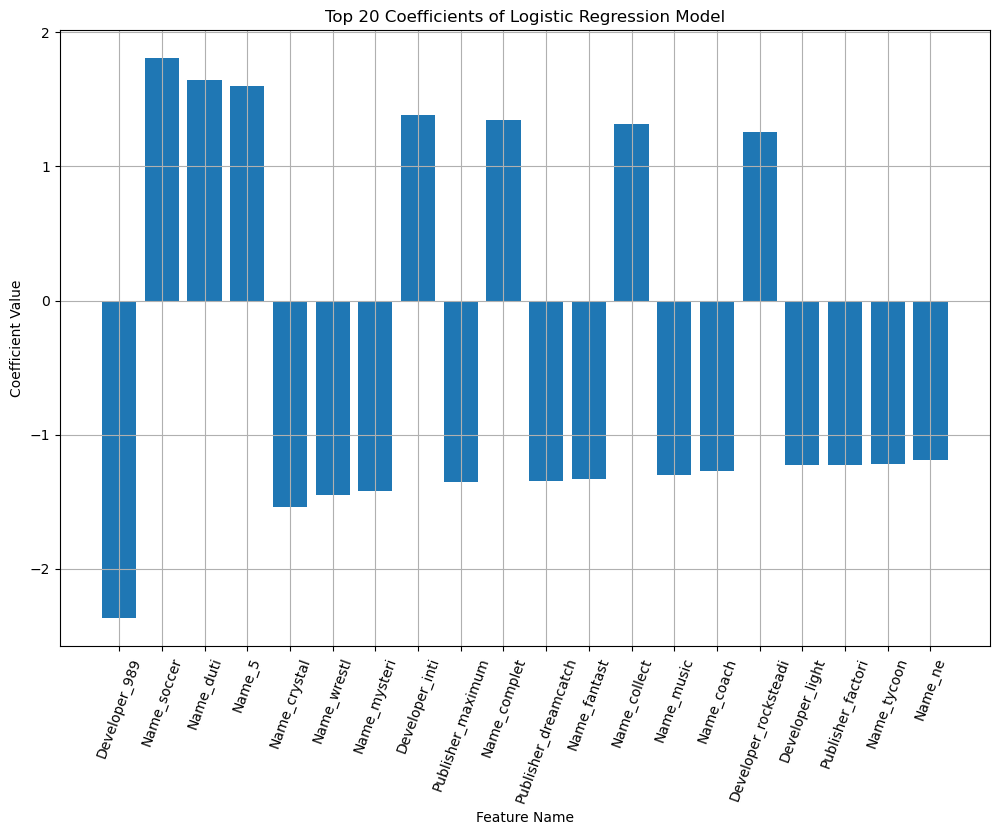

In [27]:
feature_names = X_rem_logit.columns
coefficients = baseline_logreg.coef_[0] * -1
sorted_indices = np.argsort(np.abs(coefficients))[::-1]  # Sort indices by absolute coefficient value
top_indices = sorted_indices[:20]  # Select top 20 indices

# Extract the top 20 coefficients and their corresponding feature names
top_coefficients = coefficients[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Plot the top 20 coefficients
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_coefficients)), top_coefficients)
plt.title('Top 20 Coefficients of Logistic Regression Model')
plt.xlabel('Feature Name')
plt.ylabel('Coefficient Value')
plt.xticks(range(len(top_coefficients)), top_feature_names, rotation=70)
plt.grid(True)
plt.show()

Interesting. I want to verify those and check the top 5 of both highest and lowest.
Since I think "duti" can be related to "duty", I will exclude that one.
Also, since "5" can be both alone or part of numbers when I use "contains", I will ignore this one too.

- Top 5 highest:
    - Name_soccer
    - Developer_inti
    - Name_complet
    - Name_collect
    - Developer_rocksteadi (will use rockstead)
- Top 5 lowest:
    - Developer_989
    - Name_crystal
    - Name_wrestl
    - Name_mysteri (will use myster)
    - Publisher_maximum

<div id="heading--4-1-2"/>

### 4.1.2 - Logistic Regression Top 20 coefficient distributions:

In [28]:
soccer_df = df[df['Name'].str.contains('soccer', case = False)]
inti_df = df[df['Developer'].str.contains('inti', case = False)]
complet_df = df[df['Name'].str.contains('complet', case = False)]
collect_df = df[df['Name'].str.contains('collect', case = False)]
rockstead_df = df[df['Developer'].str.contains('rockstead', case = False)]

nineeightnine_df = df[df['Developer'].str.contains('989', case = False)]
crystal_df = df[df['Name'].str.contains('crystal', case = False)]
wrestl_df = df[df['Name'].str.contains('wrestl', case = False)]
myster_df = df[df['Name'].str.contains('myster', case = False)]
maximum_df = df[df['Publisher'].str.contains('maximum', case = False)]



distribution_dfs = {'soccer_df':soccer_df, 'inti_df':inti_df,
                    'complet_df':complet_df, 'collect_df':collect_df,
                    'rockstead_df':rockstead_df, 'nineeightnine_df':nineeightnine_df,
                    'crystal_df':crystal_df, 'wrestl_df':wrestl_df,
                    'myster_df':myster_df, 'maximum_df':maximum_df}

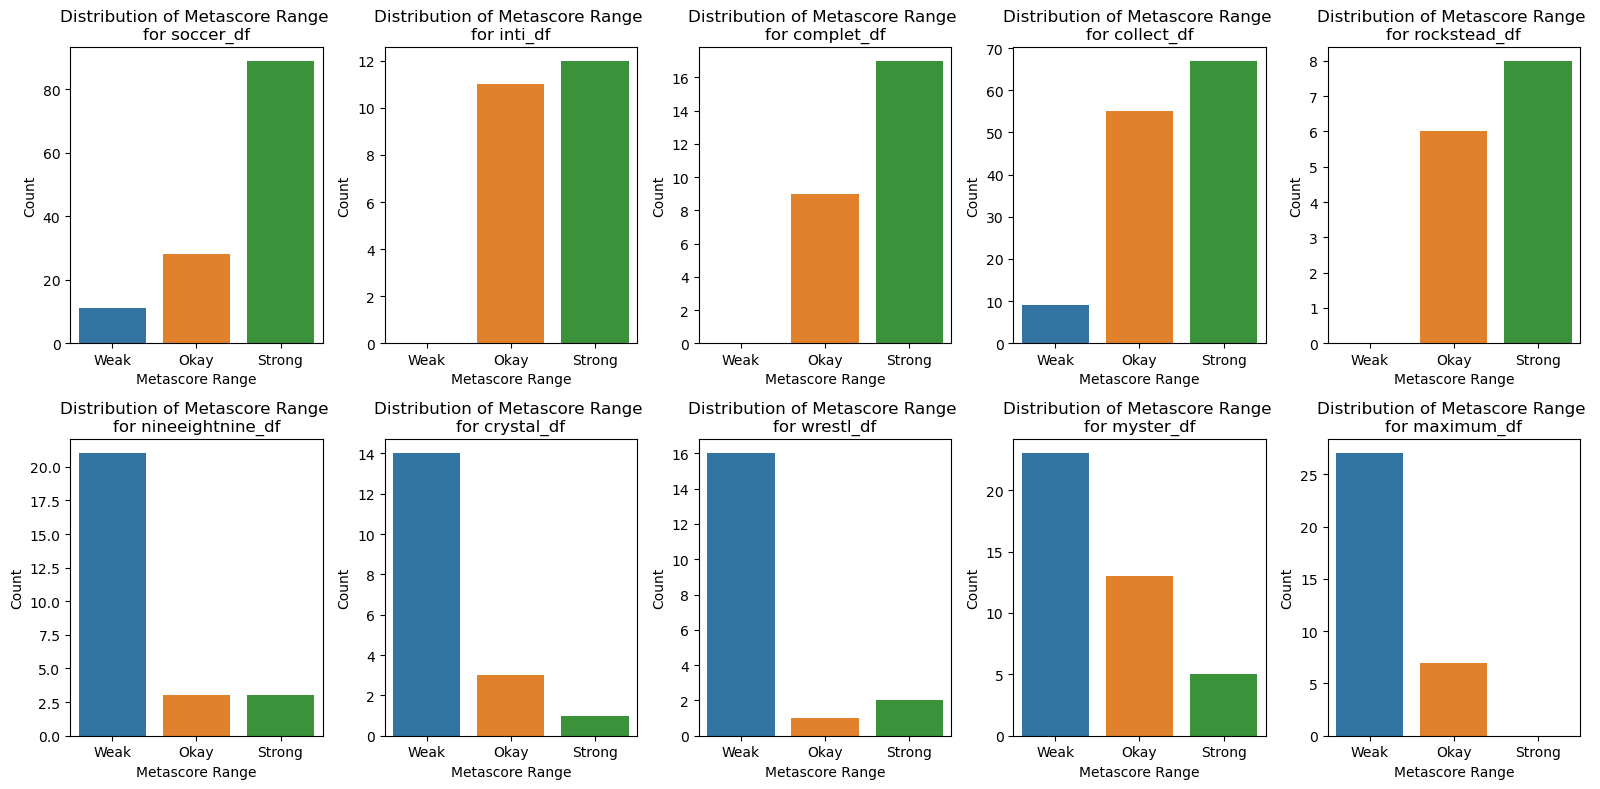

In [29]:
# Set up the figure with a 2x5 layout
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
metascore_order = ['Weak', 'Okay', 'Strong']

# Iterate over each DataFrame in the dictionary
for i, (df_name, dataframe) in enumerate(distribution_dfs.items()):
    # Calculate the row and column index for the current subplot
    row = i // 5
    col = i % 5
    
    # Set the current subplot
    ax = axes[row, col]
    
    # Plot countplot for the current DataFrame
    sns.countplot(data=dataframe, x='Metascore_Range', order = metascore_order, ax=ax)
    ax.set_title(f'Distribution of Metascore Range \nfor {df_name}')
    ax.set_xlabel('Metascore Range')
    ax.set_ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.show()

After quite a lot of time spent on trying to do some easily understandable plots, I am really satisfied with this and it's directly aligned with what the results should be. The words correlated to negative correlations are indeed because there are more "Weak"-rated games in those columns. And the words correlated to positive correlations are indeed correlated to more "Strong"-rated games in those columns.

Also, I didn't know that games about Soccer were such a good bet!
As for "complet" and "collect", I guess it's mostly related to games with "Complete Edition" or "Collection" in their name. And it makes sense: rarely would you do a Complete Edition or a Collection edition of bad games. Only good games get those treameants.

Also, not to self: never use Publishers with "maximum" in their name.

Let's do some more logistic regression modelling to try to make it a little better.

<div id="heading--4-1-3"/>

### 4.1.3 - Logistic Regression Part 2:

This time, I will iterate through c-values and check which one gives me the best accuracy.

In [30]:
%%time

# Let's try a modest range of C values
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Set up empty lists
train_accuracies = []
validation_accuracies = []

# Iterate over the C values
for value in c_values:

    # Instantiate a log reg and fit to the train set
    logreg = LogisticRegression(max_iter=10000, C=value,
                                random_state=1, n_jobs=-1).fit(X_train_logit, y_train_logit)

    # Score on the train set and append this accuracy to its respective list
    train_accuracies.append(logreg.score(X_train_logit, y_train_logit))
    
    # Score on the validation set and append this accuracy to its respective list
    validation_accuracies.append(logreg.score(X_val_logit, y_val_logit))    

CPU times: user 7.46 s, sys: 3.66 s, total: 11.1 s
Wall time: 4min 30s


Let's now plot the effect of all those different c-values in a graph.

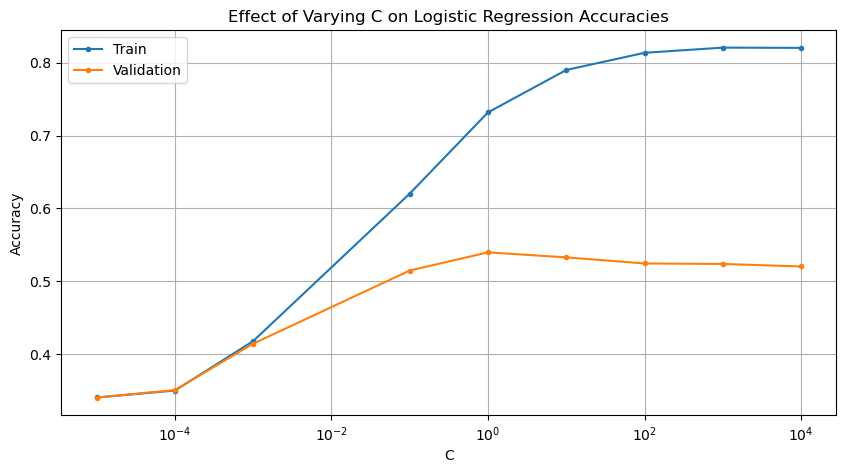

In [31]:
# Create a dataframe
scores_df=pd.DataFrame({'C value': c_values, 'train accuracy': train_accuracies, 'validation accuracy': validation_accuracies})

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.')
plt.legend()
plt.title('Effect of Varying C on Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

Even if sometimes, the c-value of 10 is a little higher than the c-value of 1, it looks like it's overfitting.
So almost always, a c-value of 1 is better in this case.

In [32]:
#c-value should be the argmax but it's overfitting, so I manually changed the best c-value to 1

# best_c=c_values[np.argmax(validation_accuracies)]
# best_c

best_c = 1

Let's do it with the validation set.

In [33]:
# Instantiate a log reg and fit to the remainder set
validated_logreg = LogisticRegression(max_iter=10000, C=best_c,
                                random_state=1, n_jobs=-1).fit(X_rem_logit, y_rem_logit)

# Print the test accuracy
print(f'Accuracy on test set: {validated_logreg.score(X_test_logit, y_test_logit)}')

Accuracy on test set: 0.5532945736434108


In [34]:
df_scores.loc[f"One-Fold : C={validated_logreg.get_params()['C']}"]=round(validated_logreg.score(X_test_logit, y_test_logit),3)
df_scores

score
Baseline log reg : C=1.0  0.553
One-Fold : C=1            0.553

I wanted to do a crossvalidation of c-values, but it was taking too long. I then tried with less values in c-values, closer to the c-value of 1.

In [35]:
%%time

# # This is the same range of C values that I used before
# c_values = [.00001, .0001, .001, 0.01, .1, 1, 10, 100, 1000, 10000]

# # Set up an empty list
# cv_accuracies = []

# # Iterate over the C values
# for value in c_values:

#     # Instantiate a log reg
#     logreg = LogisticRegression(C=value, random_state=11, n_jobs=-1, max_iter=10000)

#     # Pass the model and the remainder set into the cross-validation function, then get cross-validated accuracy by taking the mean
#     cv_accuracy = np.mean(cross_val_score(logreg, X_rem_logit, y_rem_logit, cv=5, n_jobs=-1))

#     # Append the cross-validated accuracy to the list set up above
#     cv_accuracies.append(cv_accuracy)

#     # Print something at the end of each iteration
#     print(f'For a C value of {value}, the cross-validated accuracy is {round(cv_accuracy, 6)}')





# This is the range of C values that I will use to take less time
c_values = [0.01, .1, 1, 10, 100]

# Set up an empty list
cv_accuracies = []

# Iterate over the C values
for value in c_values:

    # Instantiate a log reg
    logreg = LogisticRegression(max_iter=10000, C=value,
                                random_state=1, n_jobs=-1)

    # Pass the model and the remainder set into the cross-validation function, then get cross-validated accuracy by taking the mean
    cv_accuracy = np.mean(cross_val_score(logreg, X_rem_logit, y_rem_logit, cv=5, n_jobs=-1))

    # Append the cross-validated accuracy to the list set up above
    cv_accuracies.append(cv_accuracy)

    # Print something at the end of each iteration
    print(f'For a C value of {value}, the cross-validated accuracy is {round(cv_accuracy, 6)}')


For a C value of 0.01, the cross-validated accuracy is 0.442954
For a C value of 0.1, the cross-validated accuracy is 0.505122
For a C value of 1, the cross-validated accuracy is 0.532677
For a C value of 10, the cross-validated accuracy is 0.530737
For a C value of 100, the cross-validated accuracy is 0.522706
CPU times: user 585 ms, sys: 581 ms, total: 1.17 s
Wall time: 1min 35s


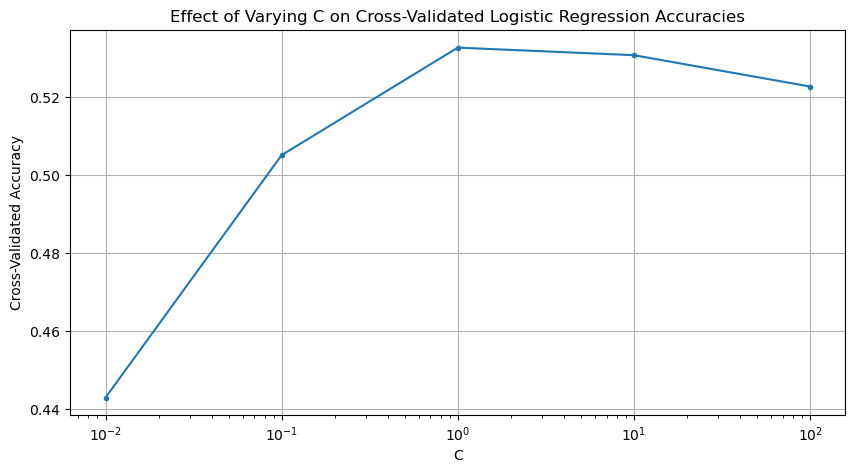

In [36]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, cv_accuracies, marker = '.')
plt.title('Effect of Varying C on Cross-Validated Logistic Regression Accuracies')
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C')
plt.ylabel('Cross-Validated Accuracy')
plt.grid()
plt.show()

It really seems like a c-value of 1 is still my best accuracy.
I will test it with the validation, add it to my score dataframe and then continue.

In [37]:
# Instantiate a log reg and fit to the remainder set
cross_validated_logreg = LogisticRegression(C=1, random_state=1).fit(X_rem_logit, y_rem_logit)

# Print the accuracies
print(f'Accuracy on remainder set: {cross_validated_logreg.score(X_rem_logit, y_rem_logit)}')
print(f'Accuracy on test set: {cross_validated_logreg.score(X_test_logit, y_test_logit)}')

df_scores.loc[f"5-Fold : C={cross_validated_logreg.get_params()['C']}"]=round(cross_validated_logreg.score(X_test_logit, y_test_logit),3)
df_scores

Accuracy on remainder set: 0.711298809194129
Accuracy on test set: 0.5526485788113695


score
Baseline log reg : C=1.0  0.553
One-Fold : C=1            0.553
5-Fold : C=1              0.553

<div id="heading--4-2"/>

## 4.2 - Pipeline test:

Now, I will do the modeling with a pipeline. I'll keep the model as logistic regression, but I'll add both a scaler and a PCA before.. Let's try it.

In [38]:
# Set up a directory to cache the pipeline results - if the same step with the same parameters is called again,
# the cached result is used instead of re-computing it.
cachedir = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline = Pipeline(steps=[
                        ('scaler', StandardScaler()),
                        ('dim_reducer', PCA()),
                        ('model', LogisticRegression(max_iter=10000, C=1,
                                random_state=1, n_jobs=-1))],
                        memory=cachedir)

In [39]:
# creating another train/test sets for the pipeline, that I will scale.
X_train_pipeline = X_train.copy()
y_train_pipeline = y_train.copy()

X_test_pipeline = X_test.copy()
y_test_pipeline = y_test.copy()

In [40]:
# testing the first pipeline

pipeline_test=my_pipeline.fit(X_train_pipeline,y_train_pipeline)
pipeline_test

Pipeline(memory='/var/folders/78/w0cjxhcs0bs0nxt9vj1kv61m0000gn/T/tmp02rmki64',
         steps=[('scaler', StandardScaler()), ('dim_reducer', PCA()),
                ('model',
                 LogisticRegression(C=1, max_iter=10000, n_jobs=-1,
                                    random_state=1))])

In [41]:
# storing the pipeline_test score in the df_scores

pipeline_test.score(X_test_pipeline,y_test_pipeline)
print(f'Accuracy on test set: {pipeline_test.score(X_test_pipeline,y_test_pipeline)}')


df_scores.loc[f"pipeline_test: "]=round(pipeline_test.score(X_test_pipeline,y_test_pipeline),3)

Accuracy on test set: 0.557245337159254


With an accuracy of 55.7%, it's a little better than with just the logistic regression. Is it due to the scaler or the slightly different dataset? I'm not sure yet.

<div id="heading--4-3"/>

## 4.3 - 6 different models:

For this part, I decided to throw 6 models in the same cell and try them all at the same time.
The only ones that have been a little tweaked are XG Boost, Random Forest and Neural Network models.

In [42]:
%%time

# testing a few different models, some have been optimized, some no
# work in progress

xgb_model = XGBClassifier(colsample_bytree= 0.75,
                          learning_rate= 0.1, max_depth= 7,
                          n_estimators= 500, subsample= 1)
ab_model = AdaBoostClassifier()
rf_model = RandomForestClassifier(max_depth= 5, max_features= 'sqrt',
                                  min_samples_leaf= 1, min_samples_split= 10, n_estimators= 300)
nn_model = MLPClassifier(hidden_layer_sizes=(5,5,5,5))
dtc_model = DecisionTreeClassifier()
bag_model = BaggingClassifier()

xgb_model.fit(X_train, y_train)
ab_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)
dtc_model.fit(X_train, y_train)
bag_model.fit(X_train, y_train)


print("Scores:")
print(f"AdaBoost train score : {ab_model.score(X_train, y_train)}")
print(f"AdaBoost test score: {ab_model.score(X_test, y_test)}")
print(f"Random Forest train score: {rf_model.score(X_train, y_train)}")
print(f"Random Forest test score: {rf_model.score(X_test, y_test)}")
print(f"XG Boost train score: {xgb_model.score(X_train, y_train)}")
print(f"XG Boost test score: {xgb_model.score(X_test, y_test)}")
print(f"NN Boost train score: {nn_model.score(X_train, y_train)}")
print(f"NN Boost test score: {nn_model.score(X_test, y_test)}")
print(f"DecisionTreeClassifier train score: {dtc_model.score(X_train, y_train)}")
print(f"DecisionTreeClassifier test score: {dtc_model.score(X_test, y_test)}")
print(f"BaggingClassifier train score: {bag_model.score(X_train, y_train)}")
print(f"BaggingClassifier test score: {bag_model.score(X_test, y_test)}")



df_scores.loc[f"AdaBoost: "]=round(ab_model.score(X_test, y_test),3)
df_scores.loc[f"Random Forest: "]=round(rf_model.score(X_test, y_test),3)
df_scores.loc[f"XG Boost: "]=round(xgb_model.score(X_test, y_test),3)
df_scores.loc[f"NN Boost: "]=round(nn_model.score(X_test, y_test),3)
df_scores.loc[f"DecisionTreeClassifier: "]=round(dtc_model.score(X_test, y_test),3)
df_scores.loc[f"BaggingClassifier: "]=round(bag_model.score(X_test, y_test),3)

Scores:
AdaBoost train score : 0.4677263035471991
AdaBoost test score: 0.47317073170731705
Random Forest train score: 0.4612327970536926
Random Forest test score: 0.4381635581061693
XG Boost train score: 0.7659430122116689
XG Boost test score: 0.5796269727403156
NN Boost train score: 0.9122892033339794
NN Boost test score: 0.5592539454806312
DecisionTreeClassifier train score: 1.0
DecisionTreeClassifier test score: 0.48809182209469154
BaggingClassifier train score: 0.9757704981585579
BaggingClassifier test score: 0.5230989956958393
CPU times: user 10min 3s, sys: 2min 26s, total: 12min 30s
Wall time: 2min 3s


Since the best model was XG Boost, I decided to focus on that one. I did a lot of testing with different dataset sizes (because of the time it took to run the code) and with a lot of different feature sizes. The following cell seems to have one of the best accuracy that I've tried.

It could be improved, but since it could almost always be improved, I decided that over 60% was not bad.

In [43]:
xgb_model = XGBClassifier(colsample_bytree= 0.75,
                          learning_rate= 0.1, max_depth= 9,
                          n_estimators= 3500, subsample= 1)

xgb_model.fit(X_train, y_train)

print(f"XG Boost, n_est=3500, train score: {xgb_model.score(X_train, y_train)}")
print(f"XG Boost, n_est=3500, test score: {xgb_model.score(X_test, y_test)}")

df_scores.loc[f"XG Boost, n_est=3500, test score: "]=round(xgb_model.score(X_test, y_test),3)

XG Boost, n_est=3500, train score: 0.9512502422950184
XG Boost, n_est=3500, test score: 0.6160688665710187


After a lot of testing, I was able to bring the XG Boost accuracy up to 61.6%. For a prediction like this, where one game rating depends on a lot of "user" factor more than tangible factors, this isn't a bad accuracy. I will try to pass it in a pipeline, maybe it will help for a few percent, just like with logistic regression above in the document.

In [44]:
%%time

# Set up a directory to cache the pipeline results - if the same step with the same parameters is called again,
# the cached result is used instead of re-computing it.
cachedir2 = mkdtemp()

# Set up a pipeline
# The steps here act as placeholders and will be changed when we pass the pipeline into the grid search later
my_pipeline2 = Pipeline(steps=[
                        ('scaler', StandardScaler()),
                        ('dim_reducer', PCA()),
                        ('model', XGBClassifier(colsample_bytree= 0.75,
                          learning_rate= 0.1, max_depth= 9,
                          n_estimators= 3500, subsample= 1))],
                        memory=cachedir2)


# creating another train/test sets for the pipeline, that I will scale.
X_train_pipeline2 = X_train.copy()
y_train_pipeline2 = y_train.copy()

X_test_pipeline2 = X_test.copy()
y_test_pipeline2 = y_test.copy()


# fitting the XGBoost pipeline
pipeline2=my_pipeline2.fit(X_train_pipeline2,y_train_pipeline2)

# calculating score and printing score
pipeline2.score(X_test_pipeline2,y_test_pipeline2)
print(f'Accuracy on test set: {pipeline2.score(X_test_pipeline2,y_test_pipeline2)}')

# storing the pipeline_test score in the df_scores
df_scores.loc[f"XGB pipeline: "]=round(pipeline2.score(X_test_pipeline2,y_test_pipeline2),3)

Accuracy on test set: 0.6172166427546628
CPU times: user 7h 29min 54s, sys: 14min 17s, total: 7h 44min 12s
Wall time: 32min 16s


In [45]:
print(f'Accuracy on train set: {pipeline2.score(X_train_pipeline2,y_train_pipeline2)}')

Accuracy on train set: 0.9999030819926342


The pipeline was able to bring the XG Boost accuracy to 61.7%. However, it became very overfitted.
From now on, I will use this to continue.

In an ideal world, I would run the below cell.
However, no matter how many time I tried, my computer would always crash.

I want to leave it in the file, if ever I get a better computer or environment in the future.

But for modelling and compilation purposes, I will tab-comment the next cell.

In [46]:
# %%time

# # work in progress, it takes a long time


# param_grid = {
#     'learning_rate': [0.1, 0.01],
#     'max_depth': [5, 7, 9, 11],
#     'n_estimators': [500, 1000, 1500, 2000, 3000, 3500],
#     'subsample': [0.5, 0.75, 1.0],
#     'colsample_bytree': [0.5, 0.75, 1.0]
# }

# # Initialize XGBoost classifier
# xgb_model = xgb.XGBClassifier()

# # Initialize GridSearchCV with the specified parameter grid and XGBoost model
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# # Perform grid search on the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters found by grid search
# print("Best parameters:", grid_search.best_params_)

# # Get the best model from grid search
# best_xgb_model = grid_search.best_estimator_

# # Evaluate the best model on the test data
# accuracy = best_xgb_model.score(X_test, y_test)
# print("Test accuracy of best model:", accuracy)

# df_scores.loc[f"Best XGB Model: "]=round(best_xgb_model.score(X_test, y_test),3)

<div id="heading--4-4-1"/>

## 4.4.1 - XG Boost Top 20 feature importances:

Out of curiosity, I want to see which feature have the most importance for XG Boost model.

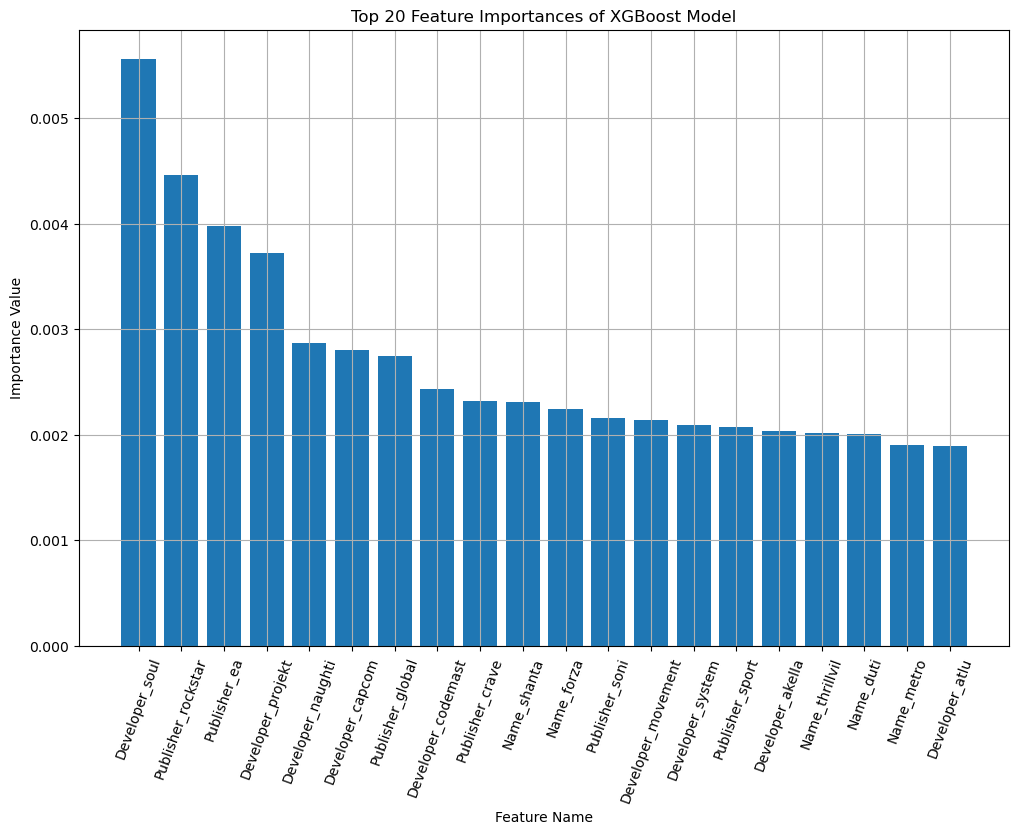

In [47]:
# Get feature names
feature_names = X_train.columns

# Get feature importances from XGBoost model
importances = xgb_model.feature_importances_

# Sort indices by feature importance value
sorted_indices = np.argsort(np.abs(importances))[::-1]

# Select top 20 indices
top_indices = sorted_indices[:20]

# Extract the top 20 feature importances and their corresponding feature names
top_importances = importances[top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.bar(range(len(top_importances)), top_importances)
plt.title('Top 20 Feature Importances of XGBoost Model')
plt.xlabel('Feature Name')
plt.ylabel('Importance Value')
plt.xticks(range(len(top_importances)), top_feature_names, rotation=70)
plt.grid(True)
plt.show()

After looking at the graph and the importance value, I realize that it's not really as simple to see which features lead to which target for XG Boost. Sadly, except saying that a developer with "Soul" or "Projekt" in their name, or a Publisher with "rockstar" or "ea" in their name is a feature in the top 20 importances, it's not really possible to say if it brings the metascore range towards a certain category.

The next cell is the same as a little above: it takes too much time but ideally, I would like to run it someday.

In [48]:
# %%time

# param_grid = {
#     'n_estimators': [100, 300, 500],
#     'max_depth': [1, 3, 5, 7, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize Random Forest classifier
# rf_model = RandomForestClassifier()

# # Initialize GridSearchCV with the specified parameter grid and Random Forest model
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# # Perform grid search on the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters found by grid search
# print("Best parameters:", grid_search.best_params_)

# # Get the best model from grid search
# best_rf_model = grid_search.best_estimator_

# # Evaluate the best model on the test data
# accuracy = best_rf_model.score(X_test, y_test)
# print("Test accuracy of best model:", accuracy)

# df_scores.loc[f"Best RF Model: "]=round(best_rf_model.score(X_test, y_test),3)

The following 2 cells are also cells that were taking forever to complete.
Parameter grid with scaler, pca and logistic regression, on 2 levels.

Keeping them for further testing in the future.

In [49]:
# %%time

# # work in progress, it takes a long time

# # Let's try the same range of C values from earlier
# c_values = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# # Parameter grid
# logreg_param_grid = [

#     # l1 with PCA
#     {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
#      'dim_reducer': [PCA()],
#      'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
#      'model': [LogisticRegression(solver='saga',penalty='l1', random_state=1, n_jobs=-1, max_iter=1000)],
#      'model__C': c_values},


#     # l2 (default) with PCA
#     {'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
#      'dim_reducer': [PCA()],
#      'dim_reducer__n_components': [0.95, 0.9, 0.85, 0.8],
#      'model': [LogisticRegression(penalty='l2',random_state=1, n_jobs=-1, max_iter=1000)],
#      'model__C': c_values}
# ]

In [50]:
# %%time

# # Instantiate the log reg grid search
# logreg_gs = GridSearchCV(my_pipeline, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=3)

# # Fit the log reg grid search
# logreg_gs.fit(X_train, y_train)

# print(f"The best logistic regression's accuracy on the train set: {logreg_gs.score(X_train, y_train)}")
# print(f"The best logistic regression's accuracy on the test set: {logreg_gs.score(X_test, y_test)}")

# df_scores.loc[f"LogReg_GS Model: "]=round(logreg_gs.score(X_test, y_test),3)

<div id="heading--5"/>

# 5. Modeling results


<div id="heading--5-1"/>
  
## 5.1 Scores

<br>

I have completed most of the modelling I wanted to do.
- I did some logistic regression and tried to optimize it.
- I did 6 different quick models.
- I chose the best one: XG Boost.
- I tried a few different ways to make XG Boost better and I improved the efficiency a little bit.

Now, let's see how it went

In [51]:
# showing all the scores
df_scores

score
Baseline log reg : C=1.0            0.553
One-Fold : C=1                      0.553
5-Fold : C=1                        0.553
pipeline_test:                      0.557
AdaBoost:                           0.473
Random Forest:                      0.438
XG Boost:                           0.580
NN Boost:                           0.559
DecisionTreeClassifier:             0.488
BaggingClassifier:                  0.523
XG Boost, n_est=3500, test score:   0.616
XGB pipeline:                       0.617

- The 3 first models are kind of similar: logistic regression with a c-value of 1. The third one has cross validation.
- The pipeline_test is a scaler, a PCA and a logistic regression. It helped, but not a lot.
- AdaBoost, Random Forest and Decision Tree Classifier: Under 50%, not useful in their current form.
- NeuralNetwork and Bagging Classifier: Not too bad, but they were overfitting, compared to XG Boost

XG Boost
- XG Boost: a few hyperparameter, didn't seem to overfit. I focused on it for the rest.
- XG Boost with n_estimators at 3500: while doing a lot of tests, I found that this one had a good accuracy and it wasn't overfitting TOO much.
- XG Boost Pipeline: Improved by .1% the accuracy, but the overfitting was through the roof.

For all those reason, my XG Boost model with n_estimators of 3500 is the best at the moment with an accuracy of 61.6%

<div id="heading--5-2"/>

## 5.2 - Confusion Matrix

<br>

Here is a confusion matrix for the best model as mentioned above, XG Boost.

In [52]:
# confusion matrix of the best model, XG Boost

# Get class predictions
y_pred = xgb_model.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix,
    columns=["Predict 1", "2", "3"],
    index=["True 1", "2", "3"]
)

display(cf_df)

Predict 1    2    3
True 1        784  293  104
2             304  577  260
3             102  275  786

In [53]:
cf_df.iloc[0,0]

784

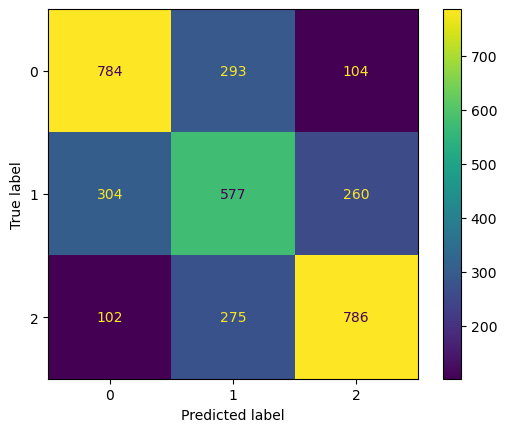

In [54]:
#better display of the confusion matrix
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test)

In [55]:
print(f'The current best accuracy with XG Boost is : {round(xgb_model.score(X_test, y_test)*100,1)}%.')

predict_0 = round(cf_df.iloc[0,0]/cf_df.iloc[0].sum()*100,1)
predict_1 = round(cf_df.iloc[1,1]/cf_df.iloc[1].sum()*100,1) 
predict_2 = round(cf_df.iloc[2,2]/cf_df.iloc[2].sum()*100,1) 
print(f'The accuracy of predicting a 0 (Weak-Rated games) is {predict_0}%.')
print(f'The accuracy of predicting a 1 (Okay-Rated games) is {predict_1}%.')
print(f'The accuracy of predicting a 2 (Strong-Rated games) is {predict_2}%.')

The current best accuracy with XG Boost is : 61.6%.
The accuracy of predicting a 0 (Weak-Rated games) is 66.4%.
The accuracy of predicting a 1 (Okay-Rated games) is 50.6%.
The accuracy of predicting a 2 (Strong-Rated games) is 67.6%.


For the prediction of class 0 (Weak-rated games) and class 2 (Strong-rated games), the model isn't too bad. But for predicting a 1 (Okay-rated games), the model is around 50%, which is not ideal.

<div id="heading--6"/>

# 6. Conclusion

So the conclusion is that the best model for the current problem is XG Boost. The accuracy is around 61.6%. It is even more accurate when predicting Weak or Strong games.

With my current limited knowledge, computer power and time, I think this is the best I can do.

But that also made me realize that modelling is an art. And it can ALWAYS be improved.

How?

- Would One-Hot Encoding the columns Names, Publisher and Developer be better?
- Are my hyperparameters optimal?
- Could I make a pipeline with more components?
- Was my dataset optimal?
- Would BagOfWords, BERT, Word2Vec or Doc2Vec be better?
- Would using only recent games be better?
- Would I have the same results if I focused only on PC gaming?

All that being said, I am happy with what this project and what it helped me practice and learn.

<div id="heading--6-1"/>

## 6.1 - Export for Streamlit deployment

I will export all my vectorizer and the best model (XG Boost) to the Models folder to be able to deploy my app on Streamlit. It was my goal from the beginning.

In [56]:
import pickle

In [57]:
# joblib.dump(xgb_model, "../Models/xgb_model.sav")

print("creating pickle file")
pickle.dump(tfidf_Name,open('../Models/name.pkl','wb'))
pickle.dump(tfidf_Publisher,open('../Models/publisher.pkl','wb'))
pickle.dump(tfidf_Developer,open('../Models/developer.pkl','wb'))
pickle.dump(xgb_model,open('../Models/xgb_model.pkl','wb'))

creating pickle file


Link to my Streamlit deployed version: https://capstoneproject-benji02.streamlit.app

QR Code to my Streamlit deployed version:

![QRCode](../Images/qrcode.png)

Thank you!

### Benjamin Lavoie (benjaminlavoie02@gmail.com)

### CapStone project: Gaming Score Forecasting Model

### Last update: March 31st, 2024 (version 3.2)